# Time Series Forecasting Exam

In this exam, you will work on a time series forecasting task. The goal is to go through the entire workflow from loading the data to evaluating the model and making predictions. Follow each step carefully. The dataset is stored in you can access it [here](https://www.kaggle.com/datasets/khaledzsa/traffic-dataset), the target is to predict `traffic_volume` column. There is also command to download the dataset below.

## Dataset: Traffic Dataset

### Dataset Overview:

- **Name**: Traffic Dataset
- **Description**: This dataset contains hourly data on the traffic volume for westbound I-94, a major interstate highway in the US that connects Minneapolis and St Paul, Minnesota. The data was collected by the Minnesota Department of Transportation (MnDOT) from 2012 to 2018 at a station roughly midway between the two cities.
- **Time Period**: Starting from 18-11-2016
- **Frequency**: Hourly observations

### Features:

1. **temp:** a numeric variable that shows the average temperature in kelvin.
2. **rain_1h:** a numeric variable that shows the amount of rain in mm that occurred in the hour.
3. **snow_1h:** a numeric variable that shows the amount of snow in mm that occurred in the hour.
4. **clouds_all:** a numeric variable that shows the percentage of cloud cover.
5. **weather_main:** a categorical variable that gives a short textual description of the current weather (such as Clear, Clouds, Rain, etc.).
6. **weather_description:** a categorical variable that gives a longer textual description of the current weather (such as light rain, overcast clouds, etc.).
7. **date_time:** a datetime variable that shows the hour of the data collected in local CST time.
8. **traffic_volume:** a numeric variable that shows the hourly I-94 reported westbound traffic volume.

#### Feel free to add or rearrange steps as you see fit to optimize your workflow. One additional note: the model's performance doesn't need to be 100% accurate. Instead, focus on achieving the best possible results while balancing performance and generalization.

## Load the Data

Load the time series dataset into a pandas DataFrame.

**Instructions:**
- Use `pandas` to load your dataset.
- Display the first few rows to understand its structure.
- Make sure the datetime column is correctly parsed.

In [1]:
# Here is a helping code that will download and unzip the dataset for you.
# Once you download the dataset you may comment the code!
!kaggle datasets download -d khaledzsa/traffic-dataset
!unzip traffic-dataset.zip

Dataset URL: https://www.kaggle.com/datasets/khaledzsa/traffic-dataset
License(s): unknown
  0% 0.00/235k [00:00<?, ?B/s]
100% 235k/235k [00:00<00:00, 70.2MB/s]
Archive:  traffic-dataset.zip
  inflating: Traffic Data.csv        


In [323]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.pipeline import make_pipeline
from sklearn.compose import make_column_transformer
from sklearn.impute import SimpleImputer #no need for this , if there is no missing values
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import timeseries_dataset_from_array
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense , LSTM , GRU
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import mean_squared_error , mean_absolute_error

In [260]:
df = pd.read_csv(
    '/content/Traffic Data.csv' ,
    parse_dates =['date_time']
)

In [261]:
df.head()

,traffic_volume,temp,rain_1h,snow_1h,clouds_all,weather_main,weather_description,date_time
0,1209.0,291.15,0.0,0.0,90,Mist,mist,2017-08-27 01:00:00
1,1248.0,286.01,0.0,0.0,1,Clear,sky is clear,2018-09-06 23:00:00
2,4602.0,293.69,0.0,0.0,75,Clouds,broken clouds,2017-08-25 18:00:00
3,2838.0,262.35,0.0,0.0,1,Clear,sky is clear,2017-11-09 22:00:00
4,5794.0,267.08,0.0,0.0,5,Clear,sky is clear,2017-11-09 15:00:00


In [262]:
for col in ['weather_main' , 'weather_description']:
  print(f'{col} : \n')
  print(df[col].value_counts())
  print()

weather_main : 

weather_main
Clear           5614
Clouds          5234
Mist            2758
Rain            2244
Snow            1462
Drizzle          993
Haze             672
Thunderstorm     542
Fog              478
Smoke              3
Name: count, dtype: int64

weather_description : 

weather_description
sky is clear                           5514
mist                                   2758
overcast clouds                        1738
broken clouds                          1574
scattered clouds                       1458
light snow                             1247
light rain                             1201
moderate rain                           747
haze                                    672
light intensity drizzle                 607
fog                                     478
few clouds                              464
proximity thunderstorm                  365
drizzle                                 346
heavy intensity rain                    184
snow                         

In [263]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20000 entries, 0 to 19999
Data columns (total 8 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   traffic_volume       19980 non-null  float64       
 1   temp                 20000 non-null  float64       
 2   rain_1h              20000 non-null  float64       
 3   snow_1h              20000 non-null  float64       
 4   clouds_all           20000 non-null  int64         
 5   weather_main         20000 non-null  object        
 6   weather_description  20000 non-null  object        
 7   date_time            20000 non-null  datetime64[ns]
dtypes: datetime64[ns](1), float64(4), int64(1), object(2)
memory usage: 1.2+ MB


In [264]:
df.describe().T #to check outliers in the dataset

,count,mean,min,25%,50%,75%,max,std
traffic_volume,19980.0,3278.186887,113.0,1228.75,3430.0,4928.0,16781.0,1977.171357
temp,20000.0,281.16268,243.39,271.95,281.825,291.84,310.07,12.661288
rain_1h,20000.0,0.048396,0.0,0.0,0.0,0.0,10.6,0.398007
snow_1h,20000.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
clouds_all,20000.0,49.3846,0.0,1.0,75.0,90.0,92.0,39.647341
date_time,20000,2017-10-22 04:13:17.939999744,2016-11-18 15:00:00,2017-04-30 14:45:00,2017-10-21 07:30:00,2018-04-13 21:00:00,2018-09-30 23:00:00,NaN


In [265]:
df.tail()

,traffic_volume,temp,rain_1h,snow_1h,clouds_all,weather_main,weather_description,date_time
19995,2723.0,296.42,0.0,0.0,40,Clouds,scattered clouds,2018-06-06 21:00:00
19996,5895.0,285.58,0.0,0.0,40,Clouds,scattered clouds,2017-10-25 15:00:00
19997,1132.0,275.30,0.0,0.0,1,Clear,sky is clear,2018-03-28 23:00:00
19998,5525.0,260.94,0.0,0.0,75,Clouds,broken clouds,2018-02-12 15:00:00
19999,5042.0,301.65,0.0,0.0,40,Clouds,scattered clouds,2018-05-31 18:00:00


In [266]:
df.set_index('date_time').index.max()

Timestamp('2018-09-30 23:00:00')

In [267]:
df.set_index('date_time').index.min()

Timestamp('2016-11-18 15:00:00')

In [268]:
df.isnull().sum().sum()

20

In [269]:
df.dropna(inplace =True)

In [270]:
df['date_without_time'] = df['date_time'].dt.date

In [271]:
df.head()

,traffic_volume,temp,rain_1h,snow_1h,clouds_all,weather_main,weather_description,date_time,date_without_time
0,1209.0,291.15,0.0,0.0,90,Mist,mist,2017-08-27 01:00:00,2017-08-27
1,1248.0,286.01,0.0,0.0,1,Clear,sky is clear,2018-09-06 23:00:00,2018-09-06
2,4602.0,293.69,0.0,0.0,75,Clouds,broken clouds,2017-08-25 18:00:00,2017-08-25
3,2838.0,262.35,0.0,0.0,1,Clear,sky is clear,2017-11-09 22:00:00,2017-11-09
4,5794.0,267.08,0.0,0.0,5,Clear,sky is clear,2017-11-09 15:00:00,2017-11-09


In [272]:
df

,traffic_volume,temp,rain_1h,snow_1h,clouds_all,weather_main,weather_description,date_time,date_without_time
0,1209.0,291.15,0.0,0.0,90,Mist,mist,2017-08-27 01:00:00,2017-08-27
1,1248.0,286.01,0.0,0.0,1,Clear,sky is clear,2018-09-06 23:00:00,2018-09-06
2,4602.0,293.69,0.0,0.0,75,Clouds,broken clouds,2017-08-25 18:00:00,2017-08-25
3,2838.0,262.35,0.0,0.0,1,Clear,sky is clear,2017-11-09 22:00:00,2017-11-09
4,5794.0,267.08,0.0,0.0,5,Clear,sky is clear,2017-11-09 15:00:00,2017-11-09
...,...,...,...,...,...,...,...,...,...
19995,2723.0,296.42,0.0,0.0,40,Clouds,scattered clouds,2018-06-06 21:00:00,2018-06-06
19996,5895.0,285.58,0.0,0.0,40,Clouds,scattered clouds,2017-10-25 15:00:00,2017-10-25
19997,1132.0,275.30,0.0,0.0,1,Clear,sky is clear,2018-03-28 23:00:00,2018-03-28
19998,5525.0,260.94,0.0,0.0,75,Clouds,broken clouds,2018-02-12 15:00:00,2018-02-12


In [273]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 19980 entries, 0 to 19999
Data columns (total 9 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   traffic_volume       19980 non-null  float64       
 1   temp                 19980 non-null  float64       
 2   rain_1h              19980 non-null  float64       
 3   snow_1h              19980 non-null  float64       
 4   clouds_all           19980 non-null  int64         
 5   weather_main         19980 non-null  object        
 6   weather_description  19980 non-null  object        
 7   date_time            19980 non-null  datetime64[ns]
 8   date_without_time    19980 non-null  object        
dtypes: datetime64[ns](1), float64(4), int64(1), object(3)
memory usage: 2.0+ MB


In [274]:
df['date_without_time'] = pd.to_datetime(df['date_without_time'])

In [275]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 19980 entries, 0 to 19999
Data columns (total 9 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   traffic_volume       19980 non-null  float64       
 1   temp                 19980 non-null  float64       
 2   rain_1h              19980 non-null  float64       
 3   snow_1h              19980 non-null  float64       
 4   clouds_all           19980 non-null  int64         
 5   weather_main         19980 non-null  object        
 6   weather_description  19980 non-null  object        
 7   date_time            19980 non-null  datetime64[ns]
 8   date_without_time    19980 non-null  datetime64[ns]
dtypes: datetime64[ns](2), float64(4), int64(1), object(2)
memory usage: 2.0+ MB


In [276]:
df.drop(columns = ['date_time'] , inplace = True)

In [277]:
df.head()

,traffic_volume,temp,rain_1h,snow_1h,clouds_all,weather_main,weather_description,date_without_time
0,1209.0,291.15,0.0,0.0,90,Mist,mist,2017-08-27
1,1248.0,286.01,0.0,0.0,1,Clear,sky is clear,2018-09-06
2,4602.0,293.69,0.0,0.0,75,Clouds,broken clouds,2017-08-25
3,2838.0,262.35,0.0,0.0,1,Clear,sky is clear,2017-11-09
4,5794.0,267.08,0.0,0.0,5,Clear,sky is clear,2017-11-09


In [278]:
dataframe = df.groupby(['date_without_time'] , as_index = False).agg(
    traffic_volume=('traffic_volume', np.sum),
    temp=('temp', np.mean),
    rain_1h=('rain_1h', np.mean),
    snow_1h=('snow_1h', np.mean),
    clouds_all=('clouds_all', np.mean),
)
dataframe

,date_without_time,traffic_volume,temp,rain_1h,snow_1h,clouds_all
0,2016-11-18,67940.0,273.582500,0.000000,0.0,85.000000
1,2016-11-19,65048.0,271.048333,0.000000,0.0,53.666667
2,2016-11-20,53556.0,269.565000,0.000000,0.0,36.500000
3,2016-11-21,78376.0,271.654583,0.000000,0.0,6.041667
4,2016-11-22,170238.0,274.069423,0.000000,0.0,81.442308
...,...,...,...,...,...,...
677,2018-09-26,88627.0,283.995833,0.010417,0.0,39.833333
678,2018-09-27,94434.0,286.268400,0.020000,0.0,61.200000
679,2018-09-28,92518.0,281.588333,0.000000,0.0,26.250000
680,2018-09-29,76242.0,278.135200,0.010000,0.0,57.360000


In [279]:
dataframe.set_index('date_without_time' , inplace = True)

In [280]:
dataframe.sort_index(inplace = True)

In [281]:
dataframe.head()

,traffic_volume,temp,rain_1h,snow_1h,clouds_all
date_without_time,,,,,
2016-11-18,67940.0,273.582500,0.0,0.0,85.000000
2016-11-19,65048.0,271.048333,0.0,0.0,53.666667
2016-11-20,53556.0,269.565000,0.0,0.0,36.500000
2016-11-21,78376.0,271.654583,0.0,0.0,6.041667
2016-11-22,170238.0,274.069423,0.0,0.0,81.442308


In [282]:
dataframe = dataframe.resample('d').mean()

## Exploratory Data Analysis (EDA)

Perform exploratory data analysis on the dataset.

**Instructions:**
- Plot the time series data.
- Analyze trends, seasonality, and potential outliers.
- Plot boxplots or scatter plots to identify any outliers or anomalies in the data.
- Seasonal Decomposition: Use `seasonal_decompose` from the `statsmodels` library to break down the time series data into trend, seasonality, and residual components. Analyze each component to gain insights into the long-term movement (trend), regular patterns (seasonality), and remaining fluctuations (residuals).

Do more if needed!

In [283]:
dataframe.duplicated().sum().sum()

0

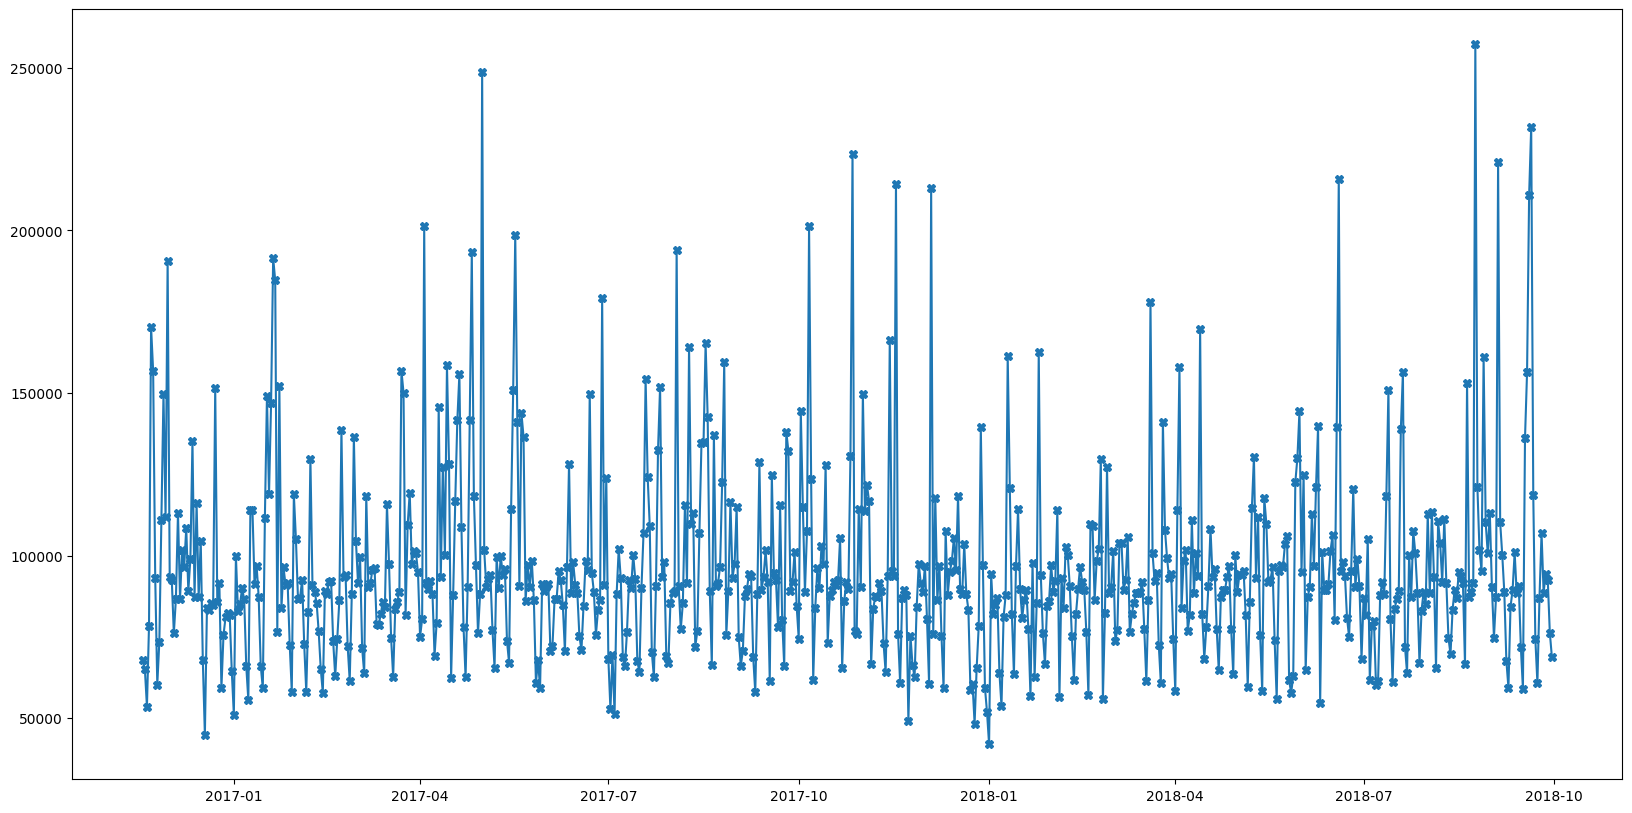

In [284]:
plt.figure(figsize = (20,10))
plt.plot(
    dataframe.index ,
    dataframe['traffic_volume'],
    marker = 'X'
)

<Axes: xlabel='date_without_time'>

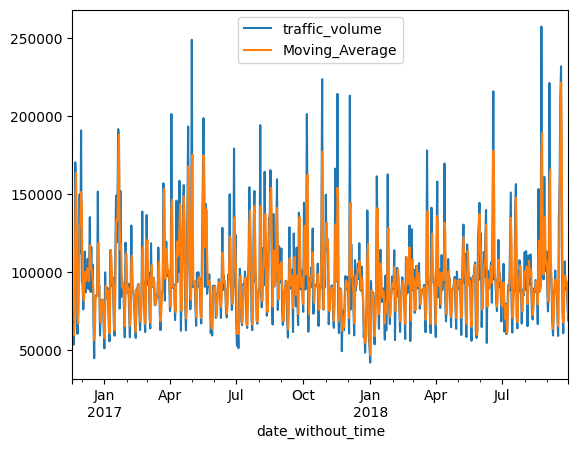

In [285]:
dataframe['Moving_Average'] = dataframe['traffic_volume'].rolling(window = 2).mean()
dataframe[['traffic_volume', 'Moving_Average']].plot()

In [286]:
result = seasonal_decompose(
    dataframe['traffic_volume'] ,
    model = 'additive'
)



result2 = seasonal_decompose(
    dataframe['traffic_volume'] ,
    model = 'multiplicative'
)


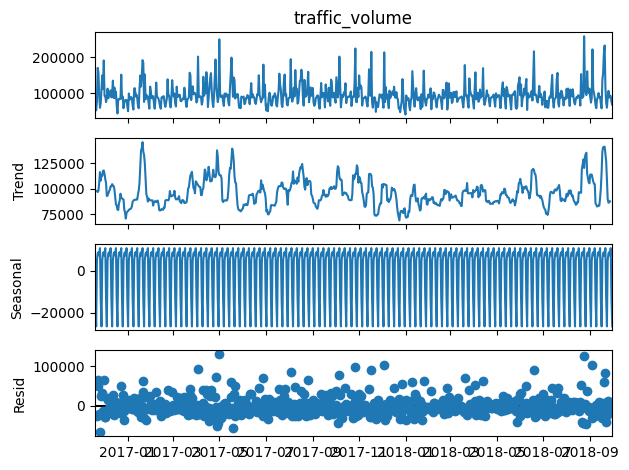

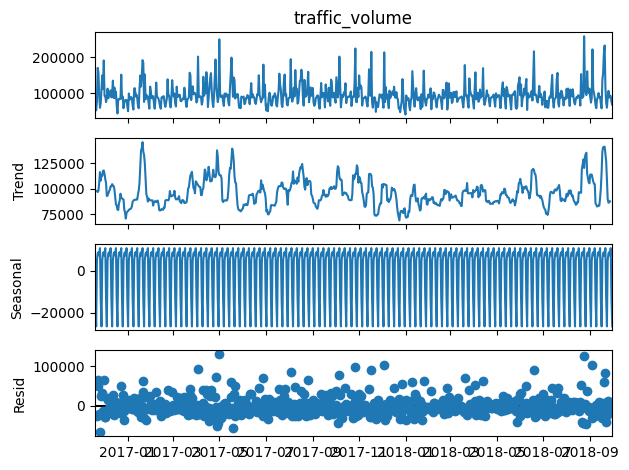

In [287]:
result.plot()

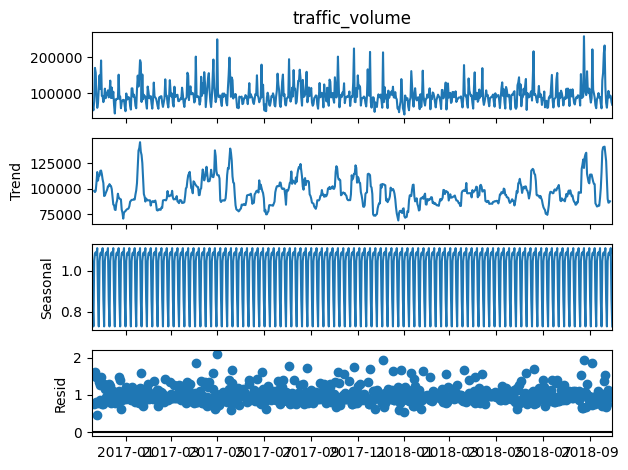

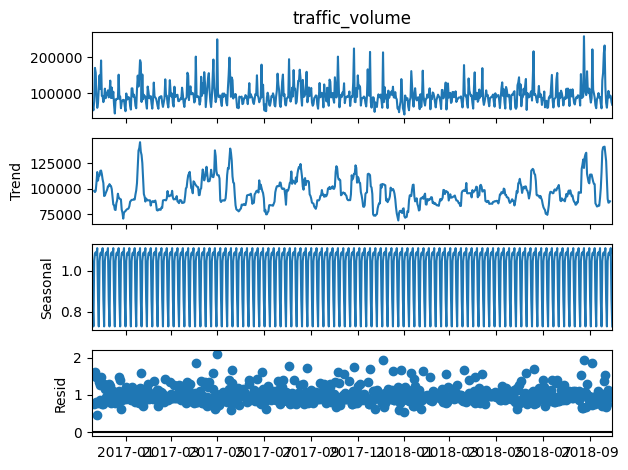

In [288]:
result2.plot()

## Data Preprocessing

Clean and preprocess the data.

**Instructions:**
- Handle any missing values in the dataset.
- If necessary, resample the data to ensure consistent time intervals.
- Create any additional features needed, such as lags or moving averages.
- Make sure that the dates are sorted correctly.

Do more if needed!

In [289]:
for i in range(2,5):
  dataframe[f'lag_{i}'] = dataframe['traffic_volume'].shift(-i)

In [290]:
dataframe.sort_index(inplace = True)

## Feature Engineering

### Instructions:
  
- **Shift Method**: Use the `shift` method to create a new column `prev_traffic_volume`, which represents the previous day's traffic volume.

- **Difference between traffic_volume**: Calculate the difference between the values in `traffic_volume` column to highlight short-term volume.

- **Date Features**: Extract meaningful time-based features from the `date_time` column to enhance the model's ability to detect temporal patterns. These features include:
  - **Day of the week**: To capture weekly seasonality.
  - **Month**: To capture monthly trends.
  - **Day of the year**: Useful for modeling yearly seasonality.


In [291]:
dataframe['prev_traffic_volume'] = dataframe['traffic_volume'].shift(-1)

In [292]:
dataframe['diff_traffic_volume'] = dataframe['traffic_volume'].diff()

In [293]:
dataframe

,traffic_volume,temp,rain_1h,snow_1h,clouds_all,Moving_Average,lag_2,lag_3,lag_4,prev_traffic_volume,diff_traffic_volume
date_without_time,,,,,,,,,,,
2016-11-18,67940.0,273.582500,0.000000,0.0,85.000000,NaN,53556.0,78376.0,170238.0,65048.0,NaN
2016-11-19,65048.0,271.048333,0.000000,0.0,53.666667,66494.0,78376.0,170238.0,156818.0,53556.0,-2892.0
2016-11-20,53556.0,269.565000,0.000000,0.0,36.500000,59302.0,170238.0,156818.0,93206.0,78376.0,-11492.0
2016-11-21,78376.0,271.654583,0.000000,0.0,6.041667,65966.0,156818.0,93206.0,60339.0,170238.0,24820.0
2016-11-22,170238.0,274.069423,0.000000,0.0,81.442308,124307.0,93206.0,60339.0,73574.0,156818.0,91862.0
...,...,...,...,...,...,...,...,...,...,...,...
2018-09-26,88627.0,283.995833,0.010417,0.0,39.833333,97733.5,92518.0,76242.0,68785.0,94434.0,-18213.0
2018-09-27,94434.0,286.268400,0.020000,0.0,61.200000,91530.5,76242.0,68785.0,NaN,92518.0,5807.0
2018-09-28,92518.0,281.588333,0.000000,0.0,26.250000,93476.0,68785.0,NaN,NaN,76242.0,-1916.0


In [294]:
dataframe['day_of_the_week'] = dataframe.index.day_of_week

In [295]:
dataframe['month'] =dataframe.index.month

In [296]:
dataframe['day_of_the_year'] = dataframe.index.day_of_year

In [ ]:
dataframe.corr()

## Feature Scaling

Apply feature scaling to the data if needed.

**Instructions:**
- Use a scaling method such as MinMaxScaler or StandardScaler.
- Ensure scaling is applied correctly to both training and testing data.

In [299]:
impute = SimpleImputer(strategy ='mean')
scaler = MinMaxScaler()

num_pipeline = make_pipeline(impute,scaler)

preprocessing = make_column_transformer(
    (num_pipeline , dataframe.columns.to_list())
)
preprocessing

ColumnTransformer(transformers=[('pipeline',
                                 Pipeline(steps=[('simpleimputer',
                                                  SimpleImputer()),
                                                 ('minmaxscaler',
                                                  MinMaxScaler())]),
                                 ['traffic_volume', 'temp', 'rain_1h',
                                  'snow_1h', 'clouds_all', 'Moving_Average',
                                  'lag_2', 'lag_3', 'lag_4',
                                  'prev_traffic_volume', 'diff_traffic_volume',
                                  'day_of_the_week', 'month',
                                  'day_of_the_year'])])

## Train-Test Split

Split the dataset into training and testing sets.

**Instructions:**
- Ensure the split maintains the time order of the data.
- Decide on an appropriate ratio for splitting the data.

In [300]:
dataframe

,traffic_volume,temp,rain_1h,snow_1h,clouds_all,Moving_Average,lag_2,lag_3,lag_4,prev_traffic_volume,diff_traffic_volume,day_of_the_week,month,day_of_the_year
date_without_time,,,,,,,,,,,,,,
2016-11-18,67940.0,273.582500,0.000000,0.0,85.000000,NaN,53556.0,78376.0,170238.0,65048.0,NaN,4,11,323
2016-11-19,65048.0,271.048333,0.000000,0.0,53.666667,66494.0,78376.0,170238.0,156818.0,53556.0,-2892.0,5,11,324
2016-11-20,53556.0,269.565000,0.000000,0.0,36.500000,59302.0,170238.0,156818.0,93206.0,78376.0,-11492.0,6,11,325
2016-11-21,78376.0,271.654583,0.000000,0.0,6.041667,65966.0,156818.0,93206.0,60339.0,170238.0,24820.0,0,11,326
2016-11-22,170238.0,274.069423,0.000000,0.0,81.442308,124307.0,93206.0,60339.0,73574.0,156818.0,91862.0,1,11,327
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2018-09-26,88627.0,283.995833,0.010417,0.0,39.833333,97733.5,92518.0,76242.0,68785.0,94434.0,-18213.0,2,9,269
2018-09-27,94434.0,286.268400,0.020000,0.0,61.200000,91530.5,76242.0,68785.0,NaN,92518.0,5807.0,3,9,270
2018-09-28,92518.0,281.588333,0.000000,0.0,26.250000,93476.0,68785.0,NaN,NaN,76242.0,-1916.0,4,9,271


In [306]:
train_valid , test = train_test_split(dataframe , test_size = 273, shuffle=False)
train , valid = train_test_split(train_valid , test_size = 365,shuffle=False)

In [307]:
train.shape , valid.shape , test.shape

((44, 14), (365, 14), (273, 14))

In [308]:
train_pre  = preprocessing.fit_transform(train)
valid_pre = preprocessing.transform(valid)
test_pre = preprocessing.transform(test)

In [311]:
window_size = 20
batch = 64


train_Xy = timeseries_dataset_from_array(train_pre , train_pre[window_size: , 0] , sequence_length = window_size , batch_size = batch )
valid_Xy = timeseries_dataset_from_array(valid_pre , test_pre[window_size: , 0] , sequence_length = window_size , batch_size = batch )
test_Xy = timeseries_dataset_from_array(test_pre , test_pre[window_size: , 0] , sequence_length = window_size , batch_size = batch )

## Models Selection

Choose two models for time series forecasting.

**Instructions:**
- Select two models such as ARIMA, SARIMA, RNN, LSTM, or GRU.
- Train these models and then compare their performance.

In [383]:
#building model architecture

model1 = Sequential(
    [
        LSTM(units = 60 , activation = 'sigmoid' , return_sequences = True)  ,
        LSTM(units = 50 , activation = 'sigmoid' , return_sequences = True) ,
        LSTM(units = 26 , activation = 'sigmoid' , return_sequences = False),
        Dense(units = 1 , activation = 'relu')
    ]
)

#compiling the model

model1.compile(
    optimizer = 'adam' ,
    loss = 'mse' ,
    metrics = ['mae']
)


### Model 1 Training

Train your first model on the training dataset.

**Instructions:**
- Fit the first model to the training data.
- Ensure to monitor the training process.

In [384]:
early  = EarlyStopping(
    monitor="val_loss",
    patience=30 ,
    restore_best_weights=True
)

#fitting the model
history1 = model1.fit(
  train_Xy ,
  validation_data = (valid_Xy) ,
  callbacks = early ,
  epochs = 1500 ,
  batch_size = batch
)

Epoch 1/1500
1/1 ━━━━━━━━━━━━━━━━━━━━ 7s 7s/step - loss: 0.0558 - mae: 0.1930 - val_loss: 0.0532 - val_mae: 0.1535
Epoch 2/1500
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 186ms/step - loss: 0.0297 - mae: 0.1241 - val_loss: 0.0400 - val_mae: 0.1228
Epoch 3/1500
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 184ms/step - loss: 0.0234 - mae: 0.1109 - val_loss: 0.0409 - val_mae: 0.1421
Epoch 4/1500
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 202ms/step - loss: 0.0295 - mae: 0.1422 - val_loss: 0.0439 - val_mae: 0.1571
Epoch 5/1500
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 207ms/step - loss: 0.0347 - mae: 0.1587 - val_loss: 0.0434 - val_mae: 0.1549
Epoch 6/1500
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 254ms/step - loss: 0.0338 - mae: 0.1561 - val_loss: 0.0409 - val_mae: 0.1425
Epoch 7/1500
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 194ms/step - loss: 0.0295 - mae: 0.1424 - val_loss: 0.0393 - val_mae: 0.1293
Epoch 8/1500
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 233ms/step - loss: 0.0253 - mae: 0.1248 - val_loss: 0.0401 - val_mae: 0.1227
Epoch 9/1500
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 187ms/step - loss:

### Make 1 Predictions

Generate predictions on the test dataset.

### Instructions:
- Use the trained model to make predictions on the test data.
- Store the predictions for further analysis.

In [385]:
test_x , test_y = next(iter(test_Xy))

In [386]:
prediction_test_1 = model1.predict(test_x)

2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step 


### Model 1 Evaluation

Evaluate the performance of your first model on the test dataset.

**Instructions:**
- Calculate evaluation metrics such as MAE, MSE, RMSE, or MAPE.
- Plot the predicted vs actual values for the test set.
- Plot the loss and the validation loss.

In [387]:
MAE = mean_absolute_error(test_y , prediction_test_1)
MSE = mean_squared_error(test_y , prediction_test_1)
RMSE = np.sqrt(MSE)

In [388]:
print(f'MAE of LSTM: {MAE}\n\n')
print(f'MSE of LSTM: {MSE}\n\n')
print(f'RMSE of LSTM: {RMSE}\n\n')

MAE of LSTM: 0.108728257405298


MSE of LSTM: 0.023139154414664857


RMSE of LSTM: 0.15211559556687426




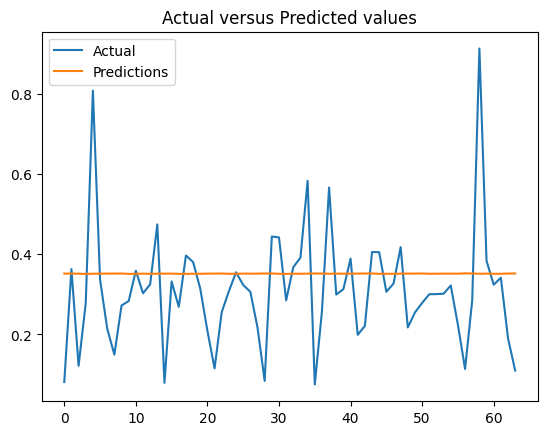

In [389]:
plt.plot(test_y , label ='Actual')
plt.plot(prediction_test_1 , label ='Predictions')
plt.title('Actual versus Predicted values')
plt.legend()
plt.show()

In [390]:
history_df_1 = pd.DataFrame(history1.history)
history_df_1.head()

,loss,mae,val_loss,val_mae
0,0.055773,0.193044,0.053190,0.153460
1,0.029707,0.124118,0.039970,0.122763
2,0.023423,0.110888,0.040876,0.142132
3,0.029478,0.142214,0.043913,0.157094
4,0.034664,0.158722,0.043395,0.154886


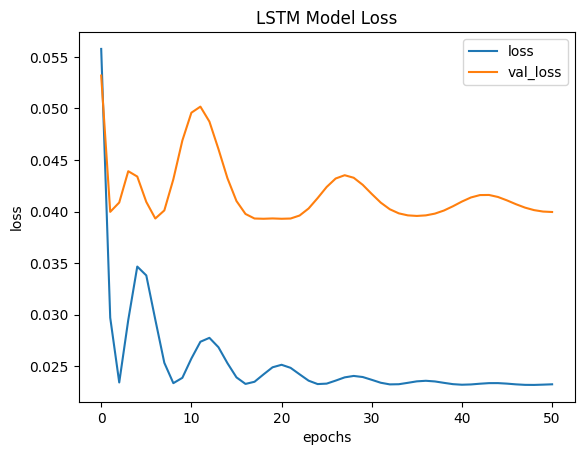

In [391]:
history_df_1[['loss' , 'val_loss']].plot()
plt.title('LSTM Model Loss')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.show()

### Model 2 Training

Train your second model on the training dataset.

**Instructions:**
- Fit the second model to the training data.
- Ensure to monitor the training process.

In [399]:
#building model architecture

model2 = Sequential(
    [
        GRU(units = 100 , activation = 'tanh' , return_sequences = True)  ,
        GRU(units = 50 , activation = 'tanh' , return_sequences = True) ,
        GRU(units = 60 , activation = 'tanh' , return_sequences = False),
        Dense(units = 1 , activation = 'relu')
    ]
)

#compiling the model

model2.compile(
    optimizer = 'adam' ,
    loss = 'mse' ,
    metrics = ['mae']
)


In [400]:
early  = EarlyStopping(
    monitor="val_loss",
    patience=20 ,
    restore_best_weights=True
)

#fitting the model
history2 = model2.fit(
  train_Xy ,
  validation_data = (valid_Xy) ,
  callbacks = early ,
  epochs = 2000 ,
  batch_size = batch
)

Epoch 1/2000
1/1 ━━━━━━━━━━━━━━━━━━━━ 7s 7s/step - loss: 0.0950 - mae: 0.2714 - val_loss: 0.1602 - val_mae: 0.3478
Epoch 2/2000
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 584ms/step - loss: 0.0238 - mae: 0.1012 - val_loss: 0.1601 - val_mae: 0.3476
Epoch 3/2000
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 649ms/step - loss: 0.0536 - mae: 0.2079 - val_loss: 0.1599 - val_mae: 0.3474
Epoch 4/2000
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 611ms/step - loss: 0.0527 - mae: 0.2062 - val_loss: 0.1597 - val_mae: 0.3471
Epoch 5/2000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 452ms/step - loss: 0.0323 - mae: 0.1497 - val_loss: 0.1594 - val_mae: 0.3468
Epoch 6/2000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 233ms/step - loss: 0.0227 - mae: 0.1030 - val_loss: 0.1590 - val_mae: 0.3463
Epoch 7/2000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 217ms/step - loss: 0.0260 - mae: 0.1107 - val_loss: 0.1585 - val_mae: 0.3456
Epoch 8/2000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 256ms/step - loss: 0.0325 - mae: 0.1357 - val_loss: 0.1579 - val_mae: 0.3447
Epoch 9/2000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 236ms/step - loss:

### Make 2 Predictions

Generate predictions on the test dataset.

### Instructions:
- Use the trained model to make predictions on the test data.
- Store the predictions for further analysis.

In [401]:
prediction_test_2 = model2.predict(test_x)

2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step 


### Model 2 Evaluation

Evaluate the performance of your second model on the test dataset.

**Instructions:**
- Calculate evaluation metrics such as MAE, MSE, RMSE, or MAPE.
- Plot the predicted vs actual values for the test set.
- Plot the loss and the validation loss.

In [402]:
MAE2 = mean_absolute_error(test_y , prediction_test_2)
MSE2 = mean_squared_error(test_y , prediction_test_2)
RMSE2 = np.sqrt(MSE2)

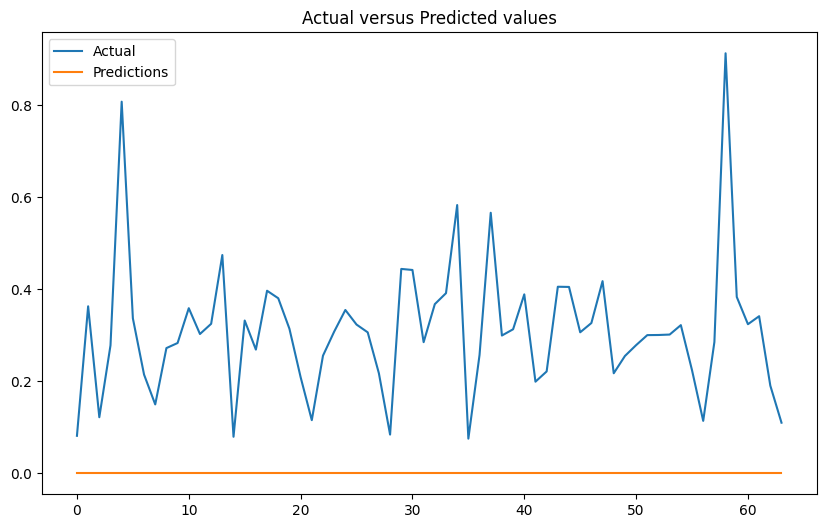

In [403]:
plt.figure(figsize=(10,6))
plt.plot(pd.DataFrame(test_y) , label='Actual')
plt.plot(pd.DataFrame(prediction_test_2) , label = 'Predictions')
plt.title('Actual versus Predicted values')
plt.legend()
plt.show()

In [404]:
history_df_2 = pd.DataFrame(history2.history)
history_df_2.head()

,loss,mae,val_loss,val_mae
0,0.094973,0.271425,0.160199,0.347786
1,0.023764,0.101217,0.160073,0.347577
2,0.053587,0.207855,0.159901,0.347352
3,0.052706,0.206157,0.159660,0.347117
4,0.032319,0.149686,0.159408,0.346841


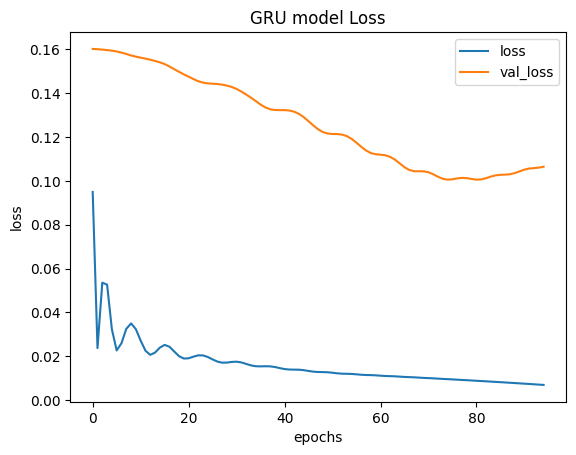

In [405]:
history_df_2[['loss' , 'val_loss']].plot()
plt.title('GRU model Loss')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.show()

## Project Questions:

1. **Data Preprocessing**: Explain How you chose your specific data preprocessing techniques (e.g., normalization, handling missing values). How did these techniques help prepare the data for training the model?
2. **Feature Engineering**: Did you perform any feature engineering or transformations? Describe your decisions and how these new features (or transformed features) contributed to the forecasting model.
3. **Model Architecture**: Describe the reasoning behind your model’s architecture (e.g., the type of model, layers, number of neurons, and activation functions). Why did you believe this architecture was appropriate for time series forecasting?
4. **Training Process**: Discuss why you chose your batch size, number of epochs, and optimizer. How did these choices affect the training process? Did you experiment with different values, and what were the outcomes?
5. **Loss Function and Metrics**: Why did you choose the specific loss function and evaluation metrics (e.g., MAE, RMSE, MAPE)? How do they align with the objective of forecasting?
6. **Model Tuning (If Done)**: Describe any tuning you performed (e.g., hyperparameter tuning) and why you felt it was necessary. How did these adjustments improve model performance?
7. **Overfitting and Underfitting**: Analyze whether the model encountered any overfitting or underfitting during training. What strategies could you implement to mitigate these issues?
8. **Future Improvements**: Suggest potential improvements or further steps you could take to enhance model performance. Consider using different algorithms, feature engineering techniques, or tuning hyperparameters.

### Answer Here:



1. **Data Preprocessing**: Explain How you chose your specific data preprocessing techniques (e.g., normalization, handling missing values). How did these techniques help prepare the data for training the model?

***
for data preprocessing I have chose to perform imputing and normalization, for the imputing I have used the mean in simpleimputer in order to fill missing values, which is better that removing them since we are dealing with a sequence.
as for the normalization I have perform MinMax scaling, to make the model fit with small ranges within the minimum and maximum of each column.
***




2. **Feature Engineering**: Did you perform any feature engineering or transformations? Describe your decisions and how these new features (or transformed features) contributed to the forecasting model.

***
I have performed multiple feature scaling, including shifting the traffic for each day by one. as well as I have included lag features to sense the dependency between the periods. I have also added the day of the week and the day of the year features.
***







3. **Model Architecture**: Describe the reasoning behind your model’s architecture (e.g., the type of model, layers, number of neurons, and activation functions). Why did you believe this architecture was appropriate for time series forecasting?


***
I have used 2 models for this task: LSTM and GRU. the reason behind this selection is that I wanted to avoid 2 famous phenomenons in the regular RNN. namely: vanishing gradient and exploding gradient. other reason is that since we are dealing with sequence data it is better to use architectures that remembers the important weights along the network. for example LSTM provides the forget gate, and the GRU provides the reset and update gates.

for the architectures:

LSTM has 3 hidden layers all with sigmoid activation function, since it is better for LSTM cells, and the output layer has the relu activation function since we are predicting the number of traffic after each 20 days (sequence window).
***




4. **Training Process**: Discuss why you chose your batch size, number of epochs, and optimizer. How did these choices affect the training process? Did you experiment with different values, and what were the outcomes?

***
for the LSTM model I have chose an epochs reaching 1500, as for the GRU I have increased it by 500 since GRU is faster than LSTM and computationally more efficent. I have performed earlystopping with patience = 20 on validation set to not waste time they reached to 51 and 95 epochs.
***


5. **Loss Function and Metrics**: Why did you choose the specific loss function and evaluation metrics (e.g., MAE, RMSE, MAPE)? How do they align with the objective of forecasting?


***
I have chose MAE for the metrics, MSE for the loss since we want to notice how great is the loss within the train and validation set , hence the squaring will maximize the loss during training which is what we want. but for the evaluation I have chose MAE so that we can get a truthful sense of the models' performance. as well as they are both regression metrics since we are predicting the number of traffic.
***



6. **Model Tuning (If Done)**: Describe any tuning you performed (e.g., hyperparameter tuning) and why you felt it was necessary. How did these adjustments improve model performance?



***
No tunning performed. however, If I had time I would apply bayesian estimation since it gives us the best approach when combining grid and random search.
***



7. **Overfitting and Underfitting**: Analyze whether the model encountered any overfitting or underfitting during training. What strategies could you implement to mitigate these issues?


both models reacted with overfitting. to avoid this I would apply some regularization technuiques, either L1 or L2. I have already applied earlystopping but it did not give me the promised result.


8. **Future Improvements**: Suggest potential improvements or further steps you could take to enhance model performance. Consider using different algorithms, feature engineering techniques, or tuning hyperparameters.


***
I would increase the dataset to overcome the problem of overfitting. I will try to use other statistical models Such as ARIMA. and for the feature engineering I would add if the day was a weekend or not, and maybe i will add a column indicating the places with most traffic.
***